<a href="https://colab.research.google.com/github/ptl-harsh/QLab_Task/blob/main/P1T2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Time series forecasting using DLinear

Note :
DLinear is a deep learning-based time series forecasting model that separates trend and seasonal components for better forecasting accuracy.

In [11]:
#@title Step 1: Install and Import Required Libraries
!pip install torch torchvision torchaudio
!pip install matplotlib pandas numpy scikit-learn

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# For reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)


In [13]:
#@title Step 2: Load and Preprocess the Data
# Upload your CSV file "exchange_rate.csv" to Colab.
# The file is assumed to have a "date" column and several numeric features.

data_path = "/exchange_rate.csv"  # Update if necessary

# Read CSV file (assuming comma-separated)
df = pd.read_csv(data_path, sep=",")

# Print column names to verify
print("Columns in CSV:", df.columns.tolist())

# Convert the 'date' column to datetime and sort the data
df['date'] = pd.to_datetime(df['date'], format="%Y/%m/%d %H:%M")
df.sort_values("date", inplace=True)
df.reset_index(drop=True, inplace=True)

# Drop the date column and use the rest as features
data = df.drop(columns=["date"]).values.astype(np.float32)

# Normalize the data feature-wise
scaler = StandardScaler()
data = scaler.fit_transform(data)

print("Data shape:", data.shape)


Columns in CSV: ['date', '0', '1', '2', '3', '4', '5', '6', 'OT']
Data shape: (7588, 8)


In [14]:
#@title Step 3: Create Sequences for Forecasting
# We'll use a historical sequence length (input) of 96 time steps and a prediction horizon of 14 time steps.

SEQ_LEN = 96
PRED_LEN = 14

def create_sequences(data, seq_len, pred_len):
    """
    Generates overlapping sequences from the data.
    data: numpy array of shape (num_timesteps, num_features)
    Returns:
      X: array of shape (num_samples, seq_len, num_features)
      y: array of shape (num_samples, pred_len, num_features)
    """
    X, y = [], []
    for i in range(len(data) - seq_len - pred_len + 1):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len : i + seq_len + pred_len])
    return np.array(X), np.array(y)

X, y = create_sequences(data, SEQ_LEN, PRED_LEN)

print("X shape:", X.shape)
print("y shape:", y.shape)

# Split data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32)


X shape: (7479, 96, 8)
y shape: (7479, 14, 8)


In [15]:
#@title Step 4: Define the DLinear Model
# DLinear is a simple linear model that directly maps the input sequence to forecasts.
# Here, we apply a linear layer to each feature channel separately.
# We first permute the input to have shape [batch, features, seq_len] and then apply a linear transformation.

class DLinear(nn.Module):
    def __init__(self, input_size, seq_len, pred_len):
        """
        input_size: number of features
        seq_len: length of the historical sequence
        pred_len: forecast horizon
        """
        super(DLinear, self).__init__()
        # We use a linear layer that takes the historical sequence (for each feature) and outputs the forecast.
        self.linear = nn.Linear(seq_len, pred_len)

    def forward(self, x):
        # x shape: [batch, seq_len, input_size]
        # Permute to [batch, input_size, seq_len] so that we apply the linear layer per feature.
        x = x.permute(0, 2, 1)
        out = self.linear(x)  # Output shape: [batch, input_size, pred_len]
        # Permute back to [batch, pred_len, input_size]
        out = out.permute(0, 2, 1)
        return out

input_size = X_train.shape[2]  # Number of features
model = DLinear(input_size, SEQ_LEN, PRED_LEN)
print(model)


DLinear(
  (linear): Linear(in_features=96, out_features=14, bias=True)
)


In [16]:
#@title Step 5: Train the DLinear Model
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 100
BATCH_SIZE = 32

# Create a DataLoader for training
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Training loop
model.train()
for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if (epoch + 1) % 10 == 0:
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {avg_loss:.6f}")


Epoch [10/100] - Loss: 0.015777
Epoch [20/100] - Loss: 0.014050
Epoch [30/100] - Loss: 0.013539
Epoch [40/100] - Loss: 0.013258
Epoch [50/100] - Loss: 0.013133
Epoch [60/100] - Loss: 0.013073
Epoch [70/100] - Loss: 0.013066
Epoch [80/100] - Loss: 0.012980
Epoch [90/100] - Loss: 0.012997
Epoch [100/100] - Loss: 0.012902


In [17]:
#@title Step 6: Evaluate the Model and Make Predictions
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()

# For evaluation, we inverse the normalization.
# Reshape predictions and true values to 2D arrays (each row corresponds to one timestep with all features).
predictions_2d = predictions.reshape(-1, input_size)
y_test_2d = y_test_np.reshape(-1, input_size)

# Inverse transform
predictions_inv = scaler.inverse_transform(predictions_2d)
y_test_inv = scaler.inverse_transform(y_test_2d)

# Reshape back to original shape: [num_samples, PRED_LEN, input_size]
predictions_final = predictions_inv.reshape(-1, PRED_LEN, input_size)
y_test_final = y_test_inv.reshape(-1, PRED_LEN, input_size)


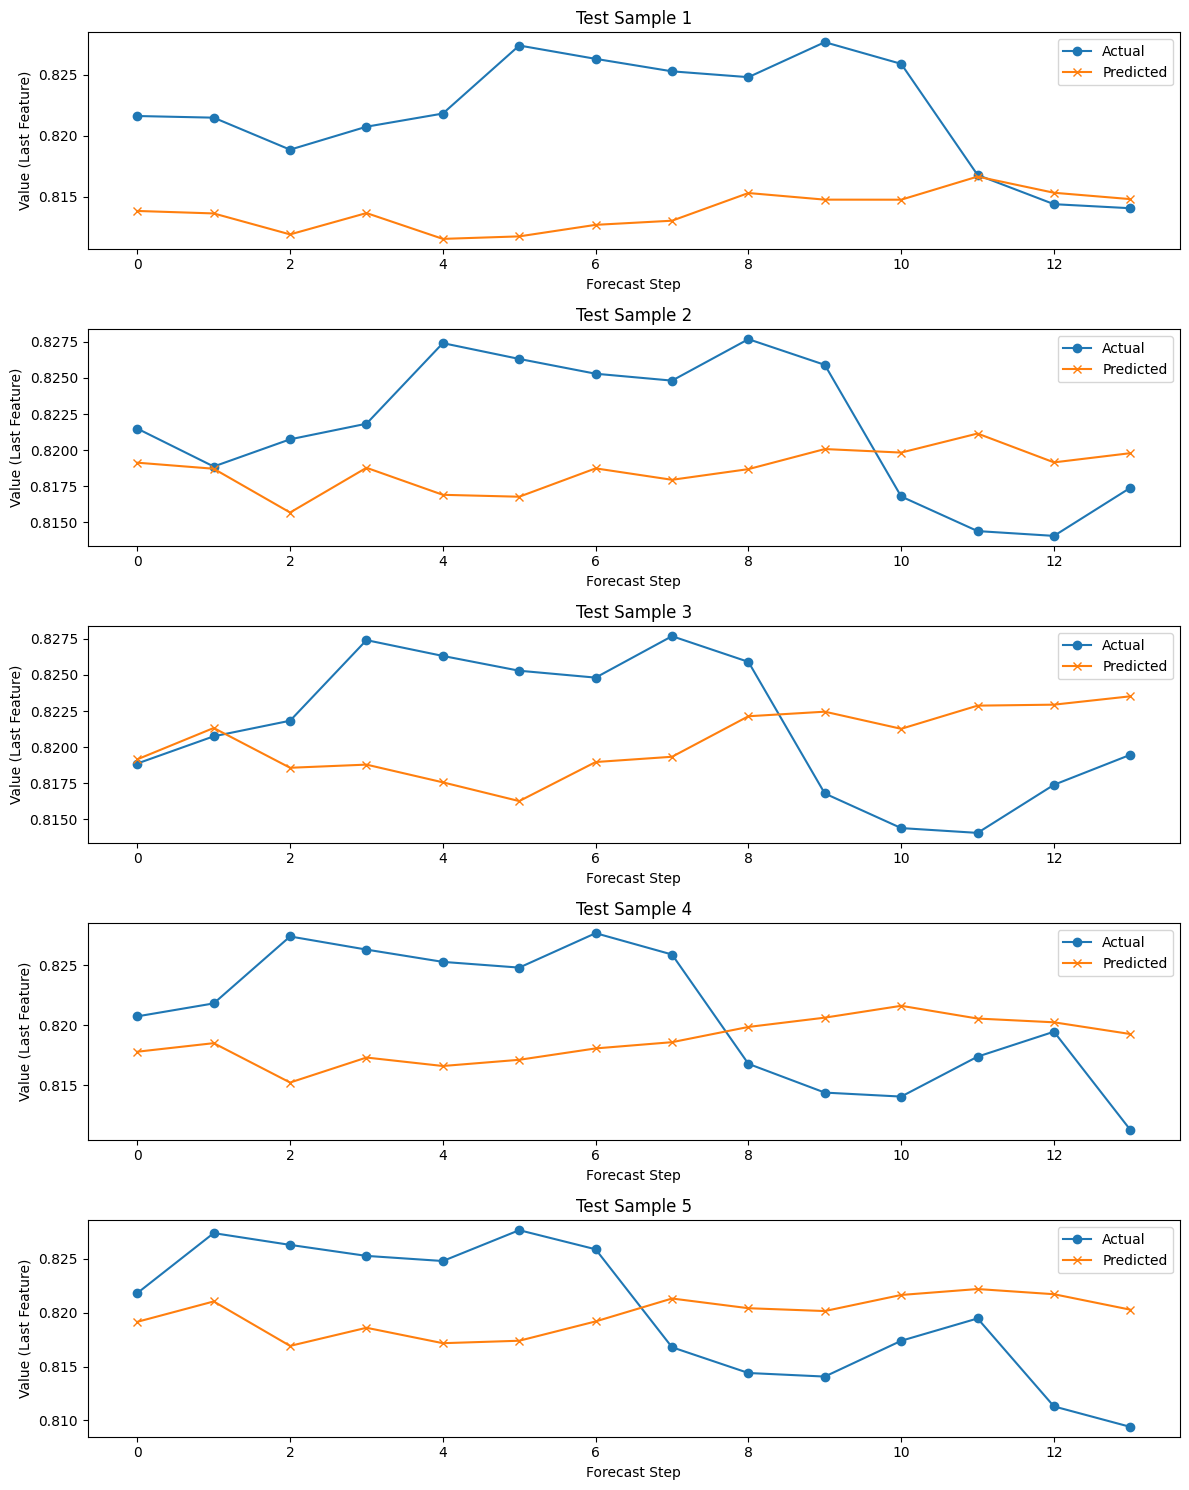

In [18]:
#@title Step 7: Visualize the Forecast Results
# For visualization, we plot the forecast of the last feature (e.g., "OT") for the first few test samples.

num_samples_to_plot = 5
plt.figure(figsize=(12, num_samples_to_plot * 3))
for i in range(num_samples_to_plot):
    plt.subplot(num_samples_to_plot, 1, i+1)
    plt.plot(y_test_final[i, :, -1], label="Actual", marker="o")
    plt.plot(predictions_final[i, :, -1], label="Predicted", marker="x")
    plt.xlabel("Forecast Step")
    plt.ylabel("Value (Last Feature)")
    plt.title(f"Test Sample {i+1}")
    plt.legend()
plt.tight_layout()
plt.show()
